<a href="_index.ipynb">&larr; FIX </a>&loz;
<a href="../../README.md"> &uarr; TOC &uarr; </a>
<img src='../_img/icon.svg' align='right' width='10%'></img>
# FIX: Fixpoint-Quantisierung im Zeitbereich #
## Quantisierung von Audiosignalen ##

In diesem Notebook wird demonstriert, wie sich Quantisierungs- und Überlaufeffekte im Zeitbereich auswirken.

Außerdem wird gezeigt, wie Audiosignale vor und nach der Requantisierung skaliert werden.

In [9]:
import os, sys
module_path = os.path.abspath(os.path.join('..')) # append dir one level up 
if module_path not in sys.path:  # ... if it hasn't been appended already
    sys.path.append(module_path)
import dsp_fpga_lib as dsp # import and set plot properties
import dsp_fpga_fix_lib as fx

import numpy as np
from numpy.fft import fft, ifft, fftshift, ifftshift, fftfreq
import scipy.signal as sig

%matplotlib inline
import matplotlib.pyplot as plt
figsize = {"figsize":(13,9)}

from ipywidgets import interactive
from IPython.display import Audio, display

import wave

np_type = np.int16 # format of audio samples
CHUNK = 1024 # number of stereo samples per frame

path = '../medien/'

#filename = 'chord.wav'
#filename = '07 - Danny Gottlieb with John McLaughlin - Duet.wav'
#filename = 'Ole_16bit.wav'
filename = '92002__jcveliz__violin-origional.wav'
#filename = 'SpaceRipple.wav'

Zunächst wird ein WAV-File geöffnet und in das Numpy-Array `samples_in` gelesen. Die meisten WAV-Files bestehen aus 16 breiten Samples (`dtype = np.int16`), bei zweikanaligen Files werden abwechselnd R / L Samples abgespeichert.

Das Audiowidget von Jupyter erwartet Numpy-Arrays im Wertebereich $-1 < x < +1$, mit der Option `normalize = True` (default) wird das Signal automatisch korrekt skaliert.

In [10]:
WAV = True
if WAV:
    wf = wave.open(os.path.join(path, filename))
    n_chan = wf.getnchannels() # number of channels in wav-file
    w_samp = wf.getsampwidth() # wordlength of samples
    f_S = wf.getframerate() # samplerate in wav-file

    x_in = np.frombuffer(wf.readframes(-1), dtype=np_type)#*0.9
    n_samples = len(x_in) // n_chan
    t = np.linspace(0,n_samples/f_S,n_samples)
else:
    n_chan = 1
    w_samp = 16
    f_S = 1e4
    n_samples = 30000
    t = np.linspace(0,n_samples/f_S,n_samples)
    x_in = 2**15 * sin(2*pi*t * 400)
    

print(f"""
Channels:\t{n_chan}\nSample width:\t{w_samp} bytes\nOutput rate:\t{f_S} Hz\n
Input Samples:\t{n_samples}""")

display(Audio(data=x_in, rate=f_S, normalize=True))


Channels:	1
Sample width:	2 bytes
Output rate:	44100 Hz

Input Samples:	220500


Das Audiosignal wird geplottet

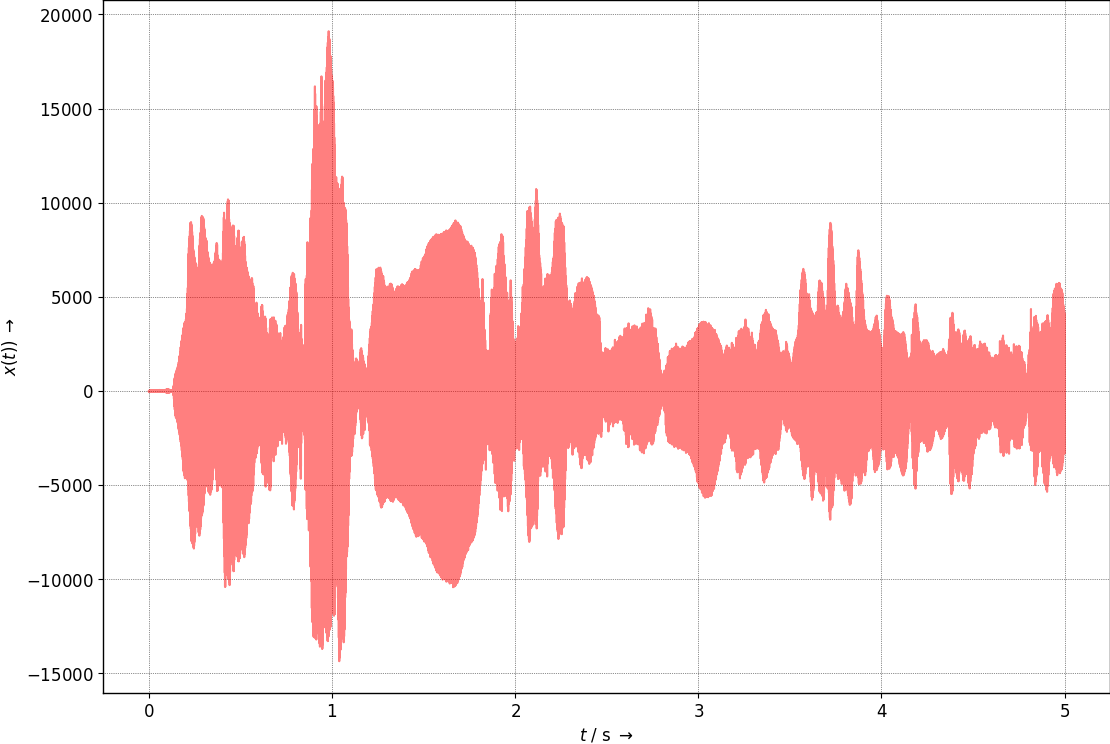

In [11]:
fig1, ax1 = plt.subplots(**figsize)
ax1.plot(t, x_in, 'r', alpha=0.5, label=r"$x(t)$")
ax1.set_ylabel(r"$x(t))\; \rightarrow$")
ax1.set_xlabel(r"$t$ / s $\rightarrow$");

Als nächstes werden die Quantisierungsparameter festgelegt und das  Numpy-Array mit den Audiodaten quantisiert. Bei Quantisierung mit Q0.15 ist der maximal darstellbare Bereich $\pm 1$. Das Signal wird daher vor der Quantisierung mit $2^{-15}$ skaliert und danach wieder mit $2^{15}$ multipliziert für eine Integerdarstellung.

In [12]:
q_obj = {'Q':0.3,'quant':'round','ovfl':'sat'} # try 'quant':'round', 'ovfl':'sat
# Overflows WI = -1 means the MSB is 2^{-1} = 0.5
#q_obj = {'Q':-1.15,'quant':'fix','ovfl':'wrap'} # try  'ovfl':'sat'

fx_Q = fx.Fixed(q_obj) 
x_q = fx_Q.fixp(x_in / 2. **15)   * 2. **15
epsilon = x_in - x_q

print(f"Q{q_obj['Q']} Quantisiertes Signal x_Q[n]:")
display(Audio(data=x_q, rate=f_S))
print(f"{fx_Q.N_over} Overflows von {fx_Q.N} Quantisierungen: ")
print("Quantisierungsfehler x_eps[n]:")
display(Audio(data=epsilon, rate=f_S))


Q0.3 Quantisiertes Signal x_Q[n]:


0 Overflows von 220500 Quantisierungen: 
Quantisierungsfehler x_eps[n]:


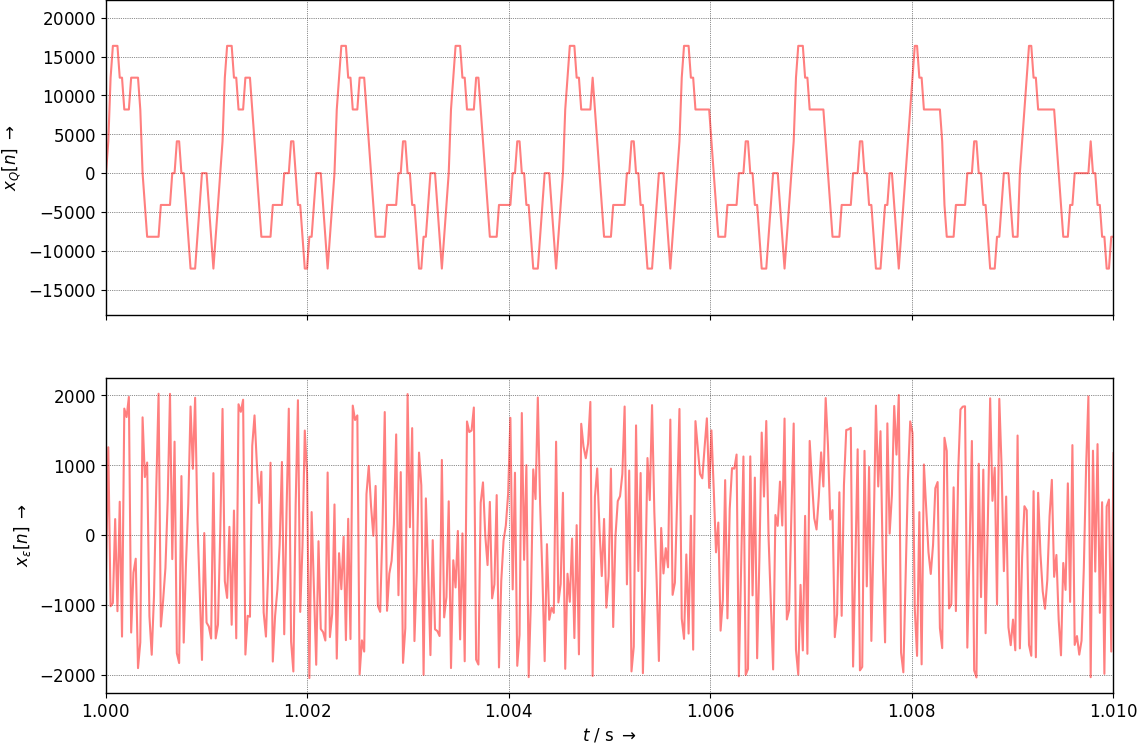

In [13]:
fig2, [ax1, ax2] = plt.subplots(nrows=2, ncols=1,sharex=True,**figsize)
ax1.plot(t, x_q, 'r', alpha=0.5, label=r"$x(t)$")
ax1.set_ylabel(r"$x_Q[n]\; \rightarrow$")
ax2.plot(t, epsilon, 'r', alpha=0.5, label=r"$\epsilon(t)$")
ax2.set_xlim((1,1.01))
ax2.set_ylabel(r"$x_{\epsilon}[n]\; \rightarrow$")
ax2.set_xlabel(r"$t$ / s $\rightarrow$");

***
### Copyright

(c) 2016 - 2021 Prof. Dr. Christian Münker 

This jupyter notebook is part of a collection of notebooks on various topics of Digital Signal Processing. The latest version can be found at https://github.com/chipmuenk/dsp.

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use it for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Christian Münker, Digital Signal Processing - Vorlesungsunterlagen mit Simulationsbeispielen, 2021*.